#BERT Classifier

In [1]:
# importing necessary libraries
import torch, os

In [2]:
# installing transformers dataset
!pip install transformers dataset

In [3]:
# using the gpu
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# loading the movie dataset
from google.colab import files
movies = files.upload()

Saving movies.csv to movies.csv


In [5]:
# creating pandas dataframe
import pandas as pd
col_names = ["genre", "split"]
data = pd.read_csv("movies.csv", sep=";", names=col_names)
data = data.sample(frac=1, random_state=42)
data.head()

,genre,split
8826,superhero,"ruling, brother. a throne would suit you ill. ..."
3172,comedy,the hotel. you'd better go straight to the bas...
9221,western,"shooting a man, son. no, it isn't. not in my o..."
718,action,that. we've only got seven minutes. passengers...
3133,comedy,the thames men later became spinal tap and had...


In [6]:
# adding labels to the dataframe
labels = ["action", "adventure", "comedy", "drama", "fantasy", "history", "scifi", "sport", "superhero", "western"]
NUM_LABELS = len(labels)
id2label = {i:l for i,l in enumerate(labels)}
label2id = {l:i for i,l in enumerate(labels)}

In [7]:
label2id

{'action': 0,
 'adventure': 1,
 'comedy': 2,
 'drama': 3,
 'fantasy': 4,
 'history': 5,
 'scifi': 6,
 'sport': 7,
 'superhero': 8,
 'western': 9}

In [8]:
data["labels"] = data.genre.map(lambda x: label2id[x.strip()])

In [9]:
data.head()

,genre,split,labels
8826,superhero,"ruling, brother. a throne would suit you ill. ...",8
3172,comedy,the hotel. you'd better go straight to the bas...,2
9221,western,"shooting a man, son. no, it isn't. not in my o...",9
718,action,that. we've only got seven minutes. passengers...,0
3133,comedy,the thames men later became spinal tap and had...,2


In [10]:
data.genre.value_counts()

comedy       1195
superhero    1000
western      1000
action       1000
history      1000
adventure    1000
sport        1000
drama        1000
scifi        1000
fantasy       995
Name: genre, dtype: int64

In [11]:
# importing BERT tokenizer and sequence classifier
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [12]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
data = data.dropna()

In [14]:
# split the data into train, val and test sets
SIZE = data.shape[0]

train_splits  = list(data.split[:SIZE//2])
val_splits    = list(data.split[SIZE//2:(3*SIZE)//4 ])
test_splits   = list(data.split[(3*SIZE)//4:])

train_labels  = list(data.labels[:SIZE//2])
val_labels    = list(data.labels[SIZE//2:(3*SIZE)//4])
test_labels   = list(data.labels[(3*SIZE)//4:])

In [15]:
len(train_splits), len(val_splits), len(test_splits)

(5082, 2541, 2541)

In [16]:
# Is the train data balanced?
data[:5095].genre.value_counts()

comedy       607
action       528
adventure    517
fantasy      505
superhero    504
history      499
sport        495
drama        486
western      479
scifi        475
Name: genre, dtype: int64

<Axes: ylabel='genre'>

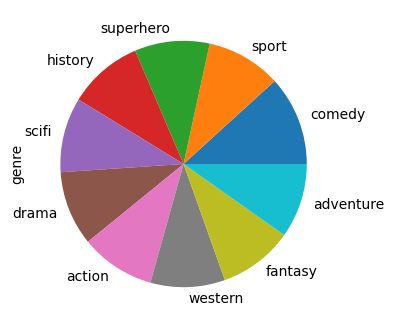

In [17]:
data.genre.value_counts().plot(kind="pie", figsize=(4,4))

In [18]:
# encode the subtitle splits
train_encodings = tokenizer(train_splits, truncation=True, padding=True)
val_encodings  = tokenizer(val_splits, truncation=True, padding=True)
test_encodings = tokenizer(test_splits, truncation=True, padding=True)

In [19]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [20]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

In [21]:
# import trainer class
from transformers import TrainingArguments, Trainer

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [23]:
!pip install --upgrade transformers
!pip install git+https://github.com/huggingface/accelerate
!pip install accelerate -U

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-5o_w8tkm
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-5o_w8tkm
  Resolved https://github.com/huggingface/accelerate to commit 54403875295905c4afb4a9435508e5262a9998c5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [24]:
# setup of the trainer
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir= './movies-BERT-Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 5.0
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

In [25]:
# Initializing the trainer class
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics= compute_metrics
)

In [26]:
# Train/fine-tune the BERT classifier
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,2.305300,2.234738,0.151909,0.113473,0.362685,0.155412
100,2.067800,1.767413,0.470681,0.438903,0.497833,0.473676
150,1.557200,1.414387,0.522629,0.499852,0.614001,0.526662
200,1.328600,1.155115,0.635970,0.638076,0.668247,0.640160
250,1.236400,0.961456,0.706021,0.708325,0.741218,0.710402
300,0.966100,0.949932,0.700512,0.700976,0.716750,0.706020
350,0.773700,0.800245,0.749311,0.754084,0.768950,0.752621
400,0.589400,0.729205,0.780008,0.782253,0.791591,0.780973
450,0.560700,0.786305,0.755214,0.758213,0.774973,0.760242
500,0.539400,0.718888,0.780795,0.782417,0.800352,0.779391


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1590, training_loss=0.46604652020541376, metrics={'train_runtime': 1557.1802, 'train_samples_per_second': 16.318, 'train_steps_per_second': 1.021, 'total_flos': 6686132138864640.0, 'train_loss': 0.46604652020541376, 'epoch': 5.0})

In [27]:
q=[trainer.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.005621,0.998819,0.998793,0.998797,0.998791
val,0.653031,0.861865,0.862587,0.863260,0.863226
test,0.671278,0.855569,0.855504,0.857003,0.855444
